In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# What are "metaparameters"?

In [ ]:
''' (Meta)parameters

- Parameters: Features of the model that are learned by the algorithm. (mainly, the weights between nodes).
                       You do not set the parameters.
- Metaparameters: Features of the model that are set by you, not learned automatically by the model.

* Many metaparameters
- Model architecture
- Number of hidden layers
- Number of units per layer
- Cross-validation sizes
- Mini-batch size
- Activation functions
- Optimization functions
- Learning rate
- Dropout
- Loss function
- Data normalization
- Weight normalization
- Weight initialization
- etc

- It is simply impossilbe to search the entire metaparameter space.
- It is difficult to know whether you are using the "best" model for your problem.
- Fortunately, parametric experiments on some metaparameters are feasible.
- Ultimately, you must use a combination of experience, intuition, previous successes, and empirical exploration.
'''

# The "wine quality" dataset

## Import and process the data

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep=';')
data

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6  

[1599 rows x 12 columns]

In [4]:
# describe the data
data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [9]:
# list number of unique values per column

for i in data.keys():
    print(f'{i} has      {len(np.unique(data[i]))} unique values')

fixed acidity has      96 unique values
volatile acidity has      143 unique values
citric acid has      80 unique values
residual sugar has      91 unique values
chlorides has      153 unique values
free sulfur dioxide has      60 unique values
total sulfur dioxide has      144 unique values
density has      436 unique values
pH has      89 unique values
sulphates has      96 unique values
alcohol has      65 unique values
quality has      6 unique values


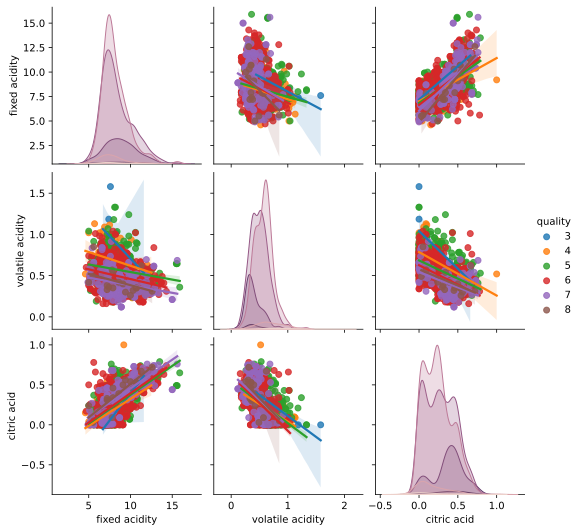

In [10]:
# pairwise plots
cols2plot = ['fixed acidity', 'volatile acidity', 'citric acid', 'quality']
sns.pairplot(data[cols2plot], kind='reg', hue='quality')
plt.show()

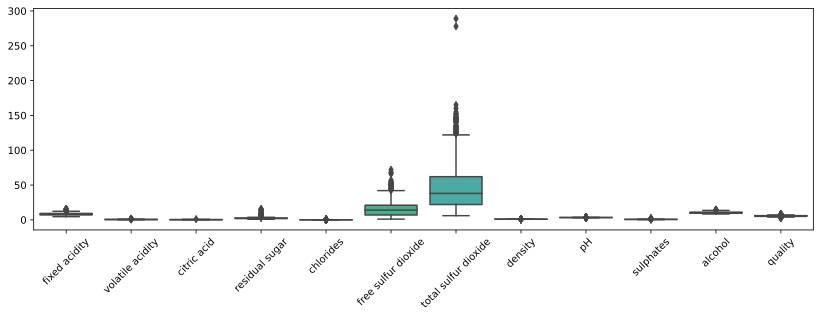

In [11]:
# plot some data
fig, ax = plt.subplots(1, figsize=(14,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [14]:
# remove rows with outliers
data_removed = data[data['total sulfur dioxide']<200].copy()

In [16]:
# z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')

# z-score (written out for clarity)
for col in cols2zscore:
    meanval = np.mean(data_removed[col])
    stdev = np.std(data_removed[col], ddof=0)
    data_removed[col] = (data_removed[col]-meanval) / stdev

# can also do more compactly
# data_removed[cols2zscore] = data_removed[cols2zscore].apply(stats.zscore)

data_removed.describe()

fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.597000e+03      1.597000e+03  1.597000e+03    1.597000e+03   
mean    3.559388e-17      1.245786e-16  1.779694e-17   -9.788316e-17   
std     1.000313e+00      1.000313e+00  1.000313e+00    1.000313e+00   
min    -2.136087e+00     -2.280762e+00 -1.391823e+00   -1.169149e+00   
25%    -7.006076e-01     -7.718255e-01 -9.286769e-01   -4.525789e-01   
50%    -2.412541e-01     -4.530063e-02 -5.384522e-02   -2.376079e-01   
75%     5.051954e-01      6.253377e-01  7.695258e-01    4.902022e-02   
max     4.352281e+00      5.878672e+00  3.754246e+00    9.292776e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.597000e+03         1.597000e+03          1.597000e+03  1.597000e+03   
mean  -1.423755e-16         8.898469e-18         -5.339081e-17 -8.361001e-14   
std    1.000313e+00         1.000313e+00          1.000313e+00  1.000313e+00   
min   -1.604575e+00        -1.422837e+00         -1.262581e+00 -3.546932e+00   
25%   -3.721412e-01        -8.478700e-01         -7.596977e-01 -6.111392e-01   
50%   -1.809014e-01        -1.770746e-01         -2.568145e-01 -6.216372e-04   
75%    5.283609e-02         4.937208e-01          4.975104e-01  5.780428e-01   
max    1.112349e+01         5.380944e+00          3.734821e+00  3.683719e+00   

                 pH     sulphates       alcohol      quality  
count  1.597000e+03  1.597000e+03  1.597000e+03  1597.000000  
mean   3.025479e-16  8.898469e-17 -5.695020e-16     5.634314  
std    1.000313e+00  1.000313e+00  1.000313e+00     0.806630  
min   -3.709380e+00 -1.937318e+00 -1.899221e+00     3.000000  
25%   -6.587444e-01 -6.392206e-01 -8.653154e-01     5.000000  
50%   -9.673073e-03 -2.261897e-01 -2.073755e-01     6.000000  
75%    5.744912e-01  4.228588e-01  6.385471e-01     6.000000  
max    4.533826e+00  7.916418e+00  4.210221e+00     8.000000

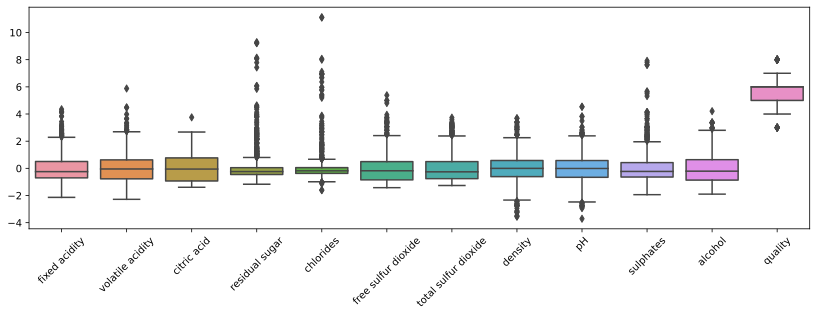

In [18]:
# check the plot again
fig, ax = plt.subplots(1, figsize=(14,4))
ax = sns.boxplot(data=data_removed)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

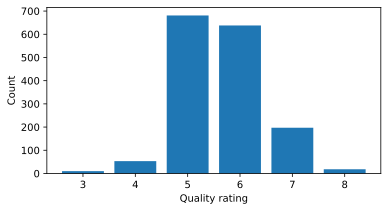

In [22]:
# distribution quality values
fig = plt.figure(figsize=(6,3))
# plt.rcParams.update({'font:size':11})

counts = data_removed['quality'].value_counts()
plt.bar(list(counts.keys()), counts)
plt.xlabel('Quality rating')
plt.ylabel('Count')
plt.show()

In [23]:
# create a new column for binarized (boolean) quality
data_removed['boolQuality'] = 0

data_removed['boolQuality'][data_removed['quality']>5]  = 1

data_removed[['quality', 'boolQuality']]

<ipython-input-23-d442a2f17dea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_removed['boolQuality'][data_removed['quality']>5]  = 1


quality  boolQuality
0           5            0
1           5            0
2           5            0
3           6            1
4           5            0
...       ...          ...
1594        5            0
1595        6            1
1596        6            1
1597        5            0
1598        6            1

[1597 rows x 2 columns]

## Re-organize the data: train/test in DataLoaders

In [24]:
# convert from pandas dataframe to tensor
data_tensor = torch.tensor(data_removed[cols2zscore].values).float()
labels = torch.tensor(data_removed['boolQuality'].values).float()

print(data_tensor.shape)
print(labels.shape)

torch.Size([1597, 11])
torch.Size([1597])


In [25]:
# we'll actually need the labels to be a "tensor"
labels = labels[:,None]
print(labels.shape)

torch.Size([1597, 1])


In [26]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize = 64
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

In [27]:
# check sizes of data batches
for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])


# Minibatch size in the wine dataset

## Import and process the data

In [28]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

<ipython-input-28-6f5cb70bcde3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


## Re-organize the data: train/test in DataLoaders

In [29]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

## Now for the DL part

In [30]:
# create a class for the model

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(11,16)

        # hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        # output layer
        self.output = nn.Linear(32,1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

## Train the model

In [31]:
# a function that trains the model

numepochs = 1000

def trainTheModel(winenet):

    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        winenet.train()

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = winenet(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append( loss.item() )
            batchAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        winenet.eval()
        X, y = next(iter(test_loader))

        with torch.no_grad():
            yHat = winenet(X)
        testAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

    return trainAcc, testAcc, losses

## Now for the experiment

In [33]:
# range of batch sizes
batchsizes = 2**np.arange(1,10,2)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(batchsizes)))
accuracyResultsTest = np.zeros((numepochs, len(batchsizes)))
comp_time = np.zeros(len(batchsizes))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

    # start the clock!
    starttime = time.process_time()

    # create data loader object
    train_loader = DataLoader(train_dataDataset, batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

    # create and train a model
    winenet = ANNwine()
    trainAcc, testAcc, _ = trainTheModel(winenet)

    # store the results
    accuracyResultsTrain[:, bi] = trainAcc
    accuracyResultsTest[:, bi] = testAcc

    # check the timer
    comp_time[bi] = time.process_time() - starttime

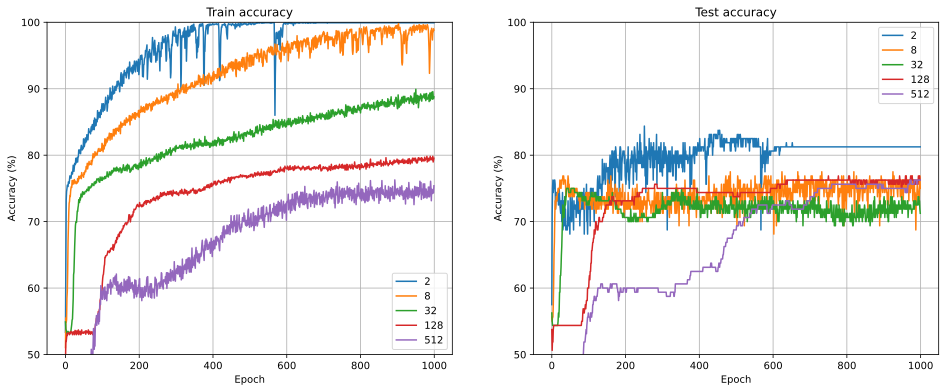

In [34]:
# plot some results
fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# for common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,100])
    ax[i].grid()

plt.show()

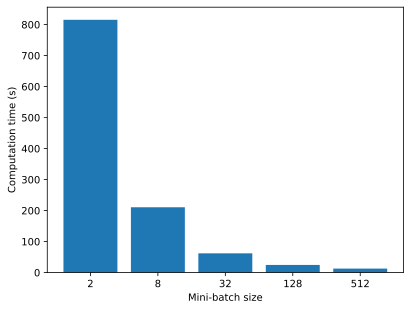

In [35]:
# bar plot of computation time
plt.bar(range(len(comp_time)), comp_time, tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()

# Data normalization

In [ ]:
''' Data normalization helps ensure that:
- All samples are processed the same.
- All data features are treated the same.
- Weights remain numerically stable.

* Z-transform
1) Mean-center: Subtract the average from each individual value.
2) Variance-normalize: Divide by the standard deviation.
3) The units are standard deviations away from the mean of the distribution.

- Z-transform shifts and stretches, but doesn't change shape.

* Min-max scaling
- Scale to a range of 0 to 1.
- Scale to a range of a to b.

* Which normalization th use?
- Oftentimes, either one is fine.
- Min-max scaling is common for images and uniform-data.
- Z-scoring is common for data that are normally distributed.
'''

# The importance of data normalization

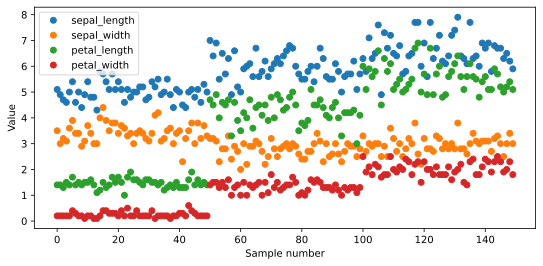

In [4]:
# import dataset
iris = sns.load_dataset('iris', cache=False)

# plot the data
iris.plot(marker='o', linestyle='none', figsize=(9,4))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

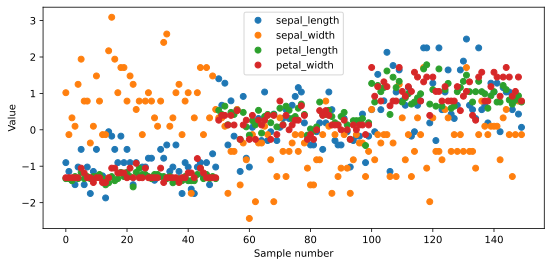

In [5]:
# z-score the data
cols2zscore = iris.keys()
cols2zscore = cols2zscore.drop('species')
iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

iris.plot(marker='o', linestyle='none', figsize=(9,4))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [6]:
# organize the data

data = torch.tensor(iris[iris.columns[:4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

## Break the data into batches

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(data,labels, test_size=.2)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=16
train_loader  = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Construct the model and training plans

In [8]:
def createANewModel():

    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )

    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.0005)

    return ANNiris, lossfunc, optimizer

In [10]:
numepochs = 2500

def trainTheModel(ANNiris, lossfunc, optimizer):

    trainAcc = []
    testAcc = []
    losses = []

    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = ANNiris(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )
            batchLoss.append(loss.item())

        trainAcc.append( np.mean(batchAcc) )
        losses.append(np.mean(batchLoss))

        X, y = next(iter(test_loader))
        predlabels = torch.argmax( ANNiris(X), axis=1 )
        testAcc.append( 100 * torch.mean((predlabels==y).float()).item() )

    return trainAcc, testAcc, losses

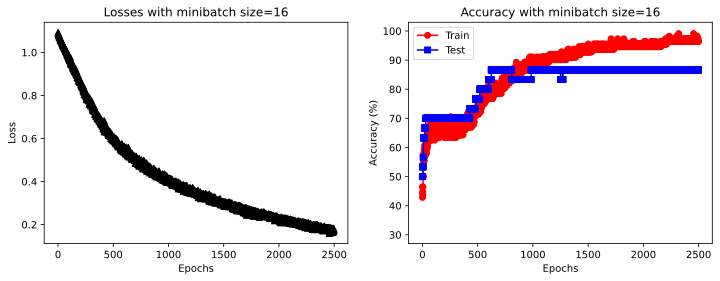

In [12]:
ANNiris, lossfunc, optimizer = createANewModel()
trainAcc, testAcc, losses = trainTheModel(ANNiris, lossfunc, optimizer)

# plot the results
fig,ax = plt.subplots(1,2,figsize=(12,4))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

# Batch normalization

In [ ]:
''' Normalize the input... which input?

- Activation distribution characteristics (mean, variance) can shift as they pass through the layers.
- This can lead to covariance shifts, or to vanishing or exploding gradients.
- Solution: Normalize inputs to each layer.
- Even better: Learn mean/variance parameters for the normalization.

* Batch normalization and train/test
- Batch normalization should only be applied during training.
- It should be switched off during validation/test, because batch size could differ (e.g., N=1).
  Instead, the model applies the learned parameters from training.
- PyTorch does this for you with net.eval()

* Discussion
- Batch normalization applies to the inputs to each layer, not to the minibatches (although it is computed per minibatch).
- Normalization is mostly useful for deep networks or datasets with low accuracy.
- Acts as a regularizer, because the input distributions are shifted and stabilized.
'''

## Import and process the data

In [13]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

<ipython-input-13-320c65f4ce84>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


## Re-organize the data: train/test in DataLoaders

In [15]:
data_tensor = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:, None]

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Now for the DL part

In [16]:
class ANNwine_withBNorm(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11,16)

        self.fc1 = nn.Linear(16,32)
        self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer
        self.fc2 = nn.Linear(32,20)
        self.bnorm2 = nn.BatchNorm1d(32) # the number of units into this layer

        self.output = nn.Linear(20, 1)

    def forward(self, x, doBN):

        # input (x starts off normalized)
        x = F.relu( self.input(x) )

        if doBN:
            # hidden layer 1
            x = self.bnorm1(x)     # batchnorm
            x = self.fc1(x)            # weighted combination
            x = F.relu(x)              # activation function

            # hidden layer 2
            x = self.bnorm2(x)     # batchnorm
            x = self.fc2(x)            # weighted combination
            x = F.relu(x)               # activation function

        else:
            # hidden layer 1
            x = F.relu(self.fc1(x))

            # hidden layer 2
            x = F.relu(self.fc2(x))

        # output layer
        return self.output(x)

## Train the model

In [17]:
# a function that trains the model

numepochs = 1000

def trainTheModel(doBN=True):

    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        winenet.train()

        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            yHat = winenet(X, doBN)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        winenet.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X, doBN)
        testAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

    return trainAcc, testAcc, losses

## Now for experiment

In [18]:
# create and train a model NO BATCHNORM
winenet = ANNwine_withBNorm()
tarinAccNo, testAccNo, lossesNo = trainTheModel(False)

# create and train a model WITH BATCHNORM
winenet = ANNwine_withBNorm()
trainAccWith, testAccWith, lossesWith = trainTheModel(True)

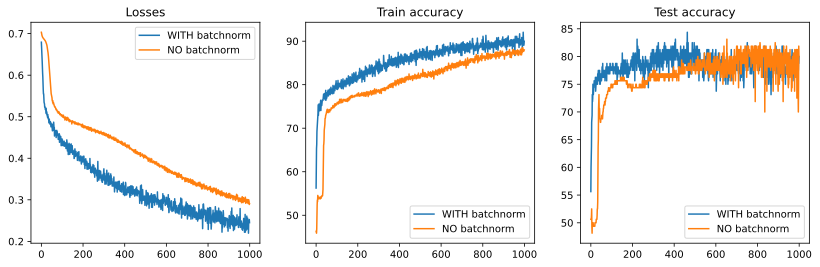

In [20]:
# plot the results
fig, ax = plt.subplots(1,3,figsize=(14,4))

ax[0].plot(lossesWith, label='WITH batchnorm')
ax[0].plot(lossesNo, label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith, label='WITH batchnorm')
ax[1].plot(tarinAccNo, label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAccWith, label='WITH batchnorm')
ax[2].plot(testAccNo, label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()

# Batch-normalize the qwerties

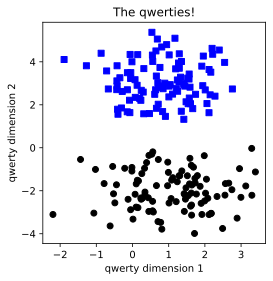

In [22]:
# create data
nPerClust = 100
blur = 1

A = [1,3]
B = [1,-2]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]

labels_np = np.vstack((
    np.zeros((nPerClust, 1)),
    np.ones((nPerClust, 1))
))

data_np = np.hstack((a,b)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

fig = plt.figure(figsize=(4,4))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## Functions to build and train the model

In [25]:
def createANNModel(learningRate):

    ANNclassify = nn.Sequential(
        nn.Linear(2,16),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        nn.Linear(16,1),
        nn.ReLU(),
        nn.BatchNorm1d(1),
        nn.Linear(1,1),
        nn.Sigmoid(),
    )

    lossfunc = nn.BCELoss()
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningRate)

    return ANNclassify, lossfunc, optimizer

In [26]:
numepochs = 1000

def trainTheModel(ANNmodel):

    losses = torch.zeros(numepochs)

    for epochi in range(numepochs):

        yHat = ANNmodel(data)

        loss = lossfunc(yHat, labels)
        losses[epochi] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    predictions = ANNmodel(data)

    total_acc = 100 * torch.mean(((predictions>.5)==labels).float()).item()

    return losses, predictions, total_acc

## Test the new code by running it once

Final accuracy: 100%


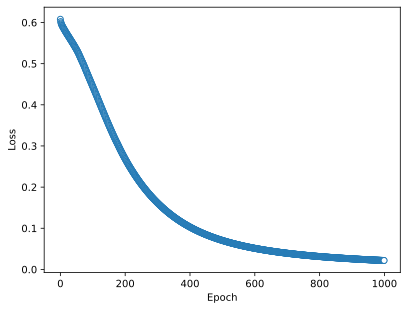

In [28]:
# create everything
ANNclassify, lossfunc, optimizer = createANNModel(.01)

# run it
losses, predictions, total_acc = trainTheModel(ANNclassify)

# report accuracy
print('Final accuracy: %g%%' % total_acc)

# show the losses
plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.show()

## Now for the real test (varying learning rates)

In [32]:
# learning rates
learning_rates = np.linspace(.001, .1, 50)

# initialize
accByLR = []
allLosses = np.zeros((len(learning_rates), numepochs))

for i, lr in enumerate(learning_rates):
    ANNclassify, lossfunc, optimizer = createANNModel(lr)
    losses, predictions, total_acc = trainTheModel(ANNclassify)

    # store the results
    accByLR.append(total_acc)
    allLosses[i,:] = losses.detach()

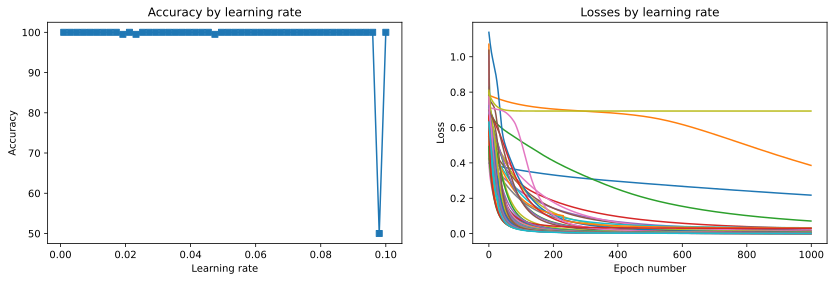

In [33]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(14,4))

ax[0].plot(learning_rates, accByLR, 's-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

plt.show()

In [34]:
accByLR

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.50000047683716,
 100.0,
 99.50000047683716,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.50000047683716,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 50.0,
 100.0]

In [35]:
sum(torch.tensor(accByLR)>70) / len(accByLR)

tensor(0.9800)